In [1]:
import numpy as np
import pandas as pd
import random
import scipy

import io
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image
import matplotlib.offsetbox as offsetbox
import matplotlib.patches as patches


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2023-04-10 19:52:50.959137: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.12.0


In [3]:
def load_csv():
    df = pd.read_csv('data/plant_list.csv')
    df.drop(['Unnamed: 1', 'Unnamed: 15'], axis=1, inplace=True)
    df.columns = [c.lower() for c in df.columns]
    df = df.rename(columns={'spacing': 'diameter'})

    bool_cols = ['dry', 'medium', 'moist', 'sun', 'partial', 'shade', 'deer resistant']
    for col in bool_cols:
        b = pd.Series([False] * df.shape[0])
        b[df[col] == 'Y'] = True
        df[col] = b
    months = {
        mon: i + 3 for i, mon in enumerate(
            ['Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct']
            )
            }
    for k, v in months.items():
        df = df.replace(k, v)
    timecols = ['mintime', 'maxtime']
    for col in timecols: df[col] = pd.to_numeric(df[col])

    df['item'] = df['plant'].apply(lambda x: clean_str(x))
    df.set_index('item', inplace=True)
    return df

def clean_str(s):
    return s.replace("'", '').replace(' ', '_').lower()

In [4]:
PLANT_COLOURS_DICT = {
    'White': 'lightyellow',
    'Yellow': 'gold',
    'Pink': 'hotpink',
    'Blue': 'lightskyblue',
    'Lavender': 'plum',
    'Purple': 'darkviolet',
    'Green': 'lawngreen',
    'Red': 'crimson',
    'Orange': 'darkorange',
}
colours = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(colour)[:3])), name)
                for name, colour in colours.items())
COLOUR_NAMES = [name for hsv, name in by_hsv if (hsv[2] < 0.8) and (0.2 < hsv[2])]

def load_square_image(filename, size):
    img = Image.open(filename)
    img = img.resize((size, size))
    
    c = np.min(np.asarray(img).shape[:2])
    img = img.crop(((size - c) // 2, 0, c + (size - c) // 2, c))
    
    return img

def generate_circle(r, n_pts=100):
    theta = np.linspace(0, 2 * np.pi, n_pts).tolist()
    return [r * np.cos(th) for th in theta], [r * np.sin(th) for th in theta]

def generate_centred_circle(x, y, r):
    x_offset, y_offset = generate_circle(r)
    return [x + xi for xi in x_offset], [y + yi for yi in y_offset]

def plot_circle(x, y, r, ax):
    x_pts, y_pts = generate_centred_circle(x, y, r)
    ax.plot(x_pts, y_pts, 'k:', linewidth=1)
    ax.set(aspect='equal')

def plot_plan(items, xy, df_inventory, dims):
    f, ax = plt.subplots()
    for i, item in enumerate(items):
        plot_circle(xy[i, 0], xy[i, 1], df_inventory.loc[item]['diameter'] / 2, ax)
    ax.plot([0, dims[0], dims[0], 0, 0], [0, 0, dims[1], dims[1], 0], 'k--', linewidth=2)
    return f, ax

def plot_plant(plant, x, y, f, ax):
    df = load_csv()
    pts_per_screen_inch = 60
    screen_inches_per_image_foot = np.max(f.get_size_inches()) / np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
    
    pts_per_image_foot = 12 * 2.54 * 5
    plant_footprint = df.loc[plant]['diameter']
    imagebox = offsetbox.OffsetImage(
        load_square_image(f'cleaned_pics/{plant}.png', int(plant_footprint * pts_per_image_foot)),
        zoom = pts_per_screen_inch * screen_inches_per_image_foot / pts_per_image_foot * 0.9
    ) 
    ax.add_artist(offsetbox.AnnotationBbox(
        imagebox, (x, y), frameon = False
    ))
    plot_circle(x, y, plant_footprint / 2, ax)
    
def plot_garden_sideview(items, xy, width, figsize_x):
    df = load_csv()

    height = df.loc[list(items)]['maxheight'].max()
    inds = np.argsort(xy[:, 1])[::-1]
    f, ax = plt.subplots(figsize=(figsize_x, figsize_x * height/width))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    for i in inds:
        plant_info = df.loc[items[i]]
        ax.add_patch(patches.Rectangle(
            (xy[i, 0] - plant_info['diameter'] / 2, 0), 
            plant_info['diameter'], np.mean([plant_info['maxheight'], plant_info['minheight']]),
            facecolor=PLANT_COLOURS_DICT[plant_info['colour']], edgecolor=[0.3] * 3, alpha=0.7,
            ))

def plot_garden_base(dims, figsize):
    width, height = dims
    f, ax = plt.subplots(1, 1, figsize=(figsize * width/height, figsize))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    return f, ax

def plot_plan(items, xy, df_inventory, dims):
    f, ax = plt.subplots()
    for i, item in enumerate(items):
        plot_circle(xy[i, 0], xy[i, 1], df_inventory.loc[item]['diameter'] / 2, ax)
    ax.plot([0, dims[0], dims[0], 0, 0], [0, 0, dims[1], dims[1], 0], 'k--', linewidth=2)
    return f, ax

def scatter_heights(items, xy, df_inventory, dims, figsize=4):
    f, ax = plot_garden_base(dims, figsize)
    # pts are 1/72 inch, i.e. 72pt/plot".  given fs plot"/1 plot, 1 plot/dims[1] real feet, 
    # i.e. 72*fs/dims[1] pts/real foot
    cm = ax.scatter(
        xy[:,0], xy[:, 1], 
        s = (
            (72 * figsize / dims[1]) ** 2
            * np.pi * (df_inventory.loc[list(items)]['diameter'].values / 2) ** 2
        ),
        c = df_inventory.loc[list(items)]['maxheight'].values,
        cmap=sns.color_palette('flare', as_cmap=True))

def plot_garden(items, xy, df_inventory, dims, figsize=10, plot_sideview=True):
    f, ax = plot_garden_base(dims, figsize)
    for i, item in enumerate(items):
        plot_plant(item, xy[i, 0], xy[i, 1], f, ax)
    if plot_sideview:
        plot_garden_sideview(items, xy, width=dims[0], figsize_x=f.get_size_inches()[1])
        f, ax = plot_garden_base(dims, 3)

In [5]:
def pick_random_spot(dims):
    scale = 1.1
    return (random.random() * dims[0] * scale - dims[0] * (scale - 1) / 2,
            random.random() * dims[1] * scale - dims[1] * (scale - 1) / 2)

def space_remaining(items, df_inventory, dims):
    return (dims[0] * dims[1] 
            - df_inventory.loc[list(items)]['diameter'].apply(lambda x: np.pi * (x/2)**2).sum())

def create_initial_plan(n_types, df_inventory, dims):
    
    choices = df_inventory[df_inventory['diameter'] < min(dims) / 2].sample(n_types)
    items, x, y = [], [], []
    # optimal packing density of uniform circles is ~90%
    buffer = 10 * 2
    while True:
        items += [choices.sample(1).index[0]]
        nx, ny = pick_random_spot(dims)
        x += [nx]
        y += [ny]

        if (space_remaining(items, df_inventory, dims)
            < buffer * (np.pi * (choices.loc[list(items)]['diameter'].mean() / 2) ** 2)): break
    print(f'{space_remaining(items, df_inventory, dims) / np.prod(dims):.0%} unused')
    return tuple(items), np.vstack((np.array(x), np.array(y))).transpose()



In [6]:
def pairwise_dist_tf(A, B):  
  """
  Computes pairwise distances between each elements of A and each elements of B.
  Args:
    A,    [m,d] matrix
    B,    [n,d] matrix
  Returns:
    D,    [m,n] matrix of pairwise distances
  """
  # squared norms of each row in A and B
  na = tf.reduce_sum(tf.square(A), 1)
  nb = tf.reduce_sum(tf.square(B), 1)
  
  # na as a row and nb as a co"lumn vectors
  na = tf.reshape(na, [-1, 1])
  nb = tf.reshape(nb, [1, -1])

  return tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0))

In [27]:
def run_gradient_descent(items, df_inventory, dims, xy):

    # This is a 
    def suboptimalness_wrapper(weights):
        # Factors going into optimisation
        def calculate_suboptimalness():
            return sum([k() * v for k, v in weights.items()])
        return calculate_suboptimalness
    def record_step(i, score):
        print(i, score.numpy())
    def run_optimise_loop(weights, n_steps, epsilon):
        opt = tf.keras.optimizers.Adam(learning_rate=epsilon)
        score = suboptimalness_wrapper(weights)()
        for i in range(n_steps):
            if n_steps < 100 or i % (n_steps // 100) == 0: record_step(i, score)
            opt.minimize(
                suboptimalness_wrapper(weights), [tf_xy]
                )
            old_score = score
            score = suboptimalness_wrapper(weights)()
            if abs(score - old_score) < epsilon:
                break
        return tf_xy
    
    # Optimisation things
    def out_of_bounds():
                below_zero = tf.reduce_sum(tf.nn.relu([[r] for r in radii] - tf_xy))
                above_max = tf.reduce_sum(tf.nn.relu(tf_xy - (np.array(dims) - [[r] for r in radii])))
                return (below_zero + above_max)
    def circles_dont_overlap():
        cr = combi_radii
        np.fill_diagonal(cr, 0)
        # want the sum of the two radii <= pairwise distance
        # and use relu to set all negative numbers (i.e. dist > radii) to zero
        return tf.reduce_sum(
            tf.reduce_sum(tf.nn.relu(cr - pairwise_dist_tf(tf_xy, tf_xy)), 1)
        ) ** 2
    def height_increases_with_y():
        min_h = min(heights)
        max_h = max(heights)
        # working towards having max_h at dims[1] and min_h at 0Y
        # Between 0 and dims[1] ft in Y, want to increase from Z from
        # ~ av. min_h to ~ av. max_h
        # i.e. want height = min_h + y / dims[1] * (max_h - min_h)
        return tf.reduce_sum(abs(
            tf_xy[:, 1] * (max_h - min_h) / (dims[1] - max(radii)) + min_h - heights
        ))

    # Break out the inventory into useful items
    radii = df_inventory.loc[list(items)]['diameter'].values.astype('float32') / 2
    combi_radii = radii.reshape((len(items), 1)) + radii.reshape((1, len(items)))
    heights = df_inventory.loc[list(items)]['maxheight'].values.astype('float32')
    
    tf_xy = tf.Variable(xy, dtype='float32')
    
    # Stage One - 
    tf_xy = run_optimise_loop(
        n_steps=100, epsilon=0.1, 
        weights={out_of_bounds: 1, height_increases_with_y: 10, circles_dont_overlap:1e-5}
    )
    # Stage Two
    tf_xy = run_optimise_loop(
        n_steps = int(1e5), epsilon = 1e-3, weights={out_of_bounds: 1, circles_dont_overlap: 1}
    )

        
    return tf_xy.numpy()



14% unused
0 1452.6128
1 1433.5972
2 1415.0974
3 1396.7457
4 1378.5101
5 1360.6473
6 1343.5808
7 1326.4764
8 1309.271
9 1292.0541
10 1275.8192
11 1259.4279
12 1242.9739
13 1227.1237
14 1211.7346
15 1196.1719
16 1180.6897
17 1165.0408
18 1149.2802
19 1133.5845
20 1118.2017
21 1102.8151
22 1087.3845
23 1072.3606
24 1057.1105
25 1041.7815
26 1027.4498
27 1013.4167
28 999.1714
29 985.12915
30 971.2591
31 957.70074
32 944.24915
33 931.2005
34 918.6272
35 906.6515
36 894.4684
37 882.5817
38 870.4228
39 858.3629
40 846.2668
41 833.8049
42 821.34875
43 808.6415
44 795.86646
45 783.0832
46 770.52246
47 757.7243
48 744.92017
49 732.98047
50 721.1695
51 709.224
52 697.3699
53 685.8824
54 674.3411
55 663.04694
56 651.5057
57 640.28955
58 629.1307
59 617.9507
60 607.1404
61 596.75085
62 587.39435
63 577.78937
64 568.3836
65 559.0967
66 549.6422
67 539.6883
68 529.7782
69 520.31586
70 510.9877
71 501.2387
72 491.23706
73 481.2167
74 471.59085
75 462.7076
76 454.18436
77 445.75015
78 437.5386
79 429.

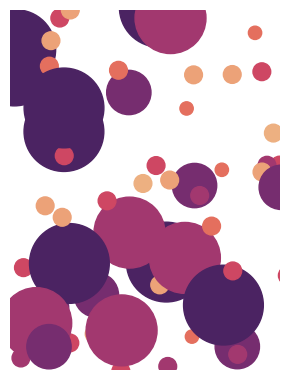

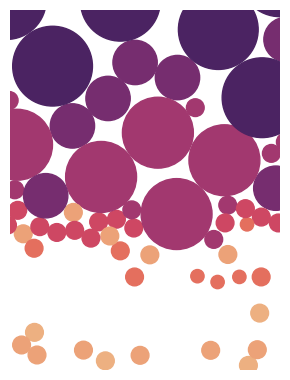

In [26]:
df_inventory = load_csv()
dims = (15, 20);
items, xy = create_initial_plan(10, df_inventory, dims)
scatter_heights(items, xy, df_inventory, dims, 4)
xy_new = run_gradient_descent(items, df_inventory, dims, xy)
scatter_heights(items, xy_new, df_inventory, dims, 4);

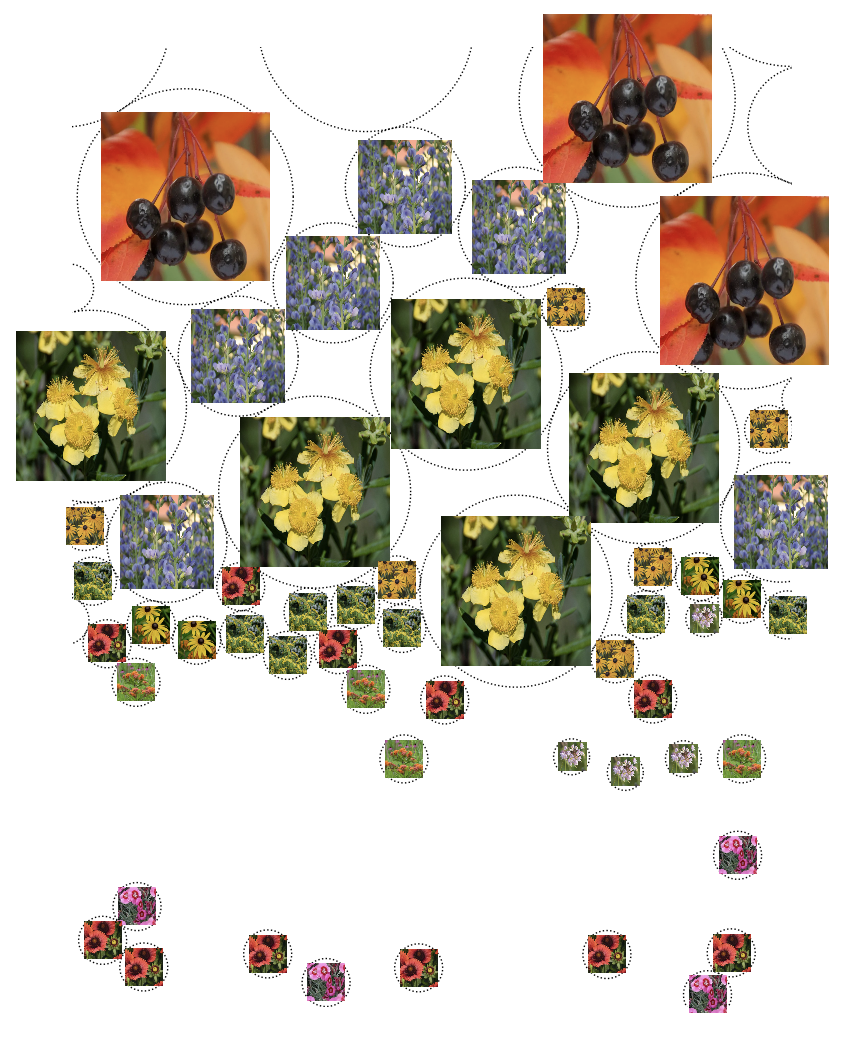

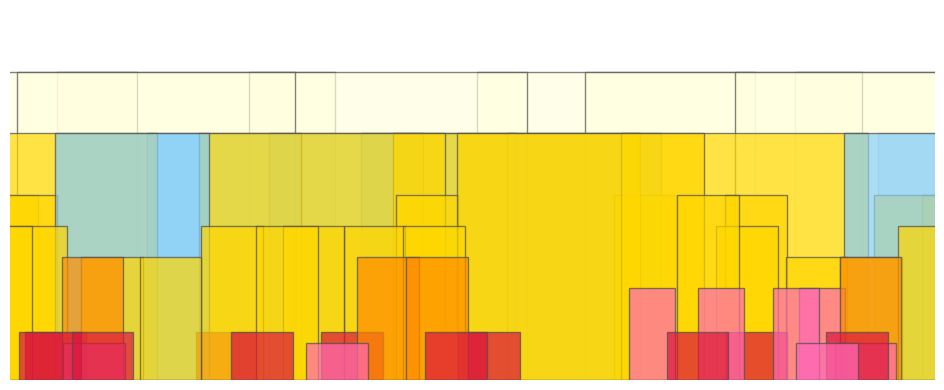

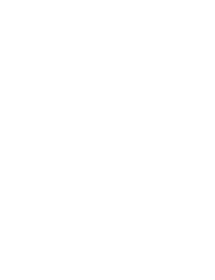

In [28]:
plot_garden(items, xy_new, df_inventory, dims)